In [1]:
! pip install matplotlib opencv-python pandas numpy seaborn tqdm scikit-learn

  Using cached matplotlib-3.8.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.2.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.51.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (159 kB)
  Using cached kiwisolver-1.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached tzdata-2024.1-py2.py3-none-an

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from torchvision import models
import torchvision

import numpy as np
import matplotlib.pyplot as plt


In [3]:
# helper function
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize=(5, 15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")
    plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


<h1> Prepare Data</h1>

In [44]:
from datasetv2 import datasetv3
from ad_labels import LABELS_MAP, LABELS_LIST

batch_size = 128
resize = 299
train_loader, test_loader, train_dataset, test_dataset = datasetv3(resize)

100%|██████████| 4/4 [00:00<00:00, 518.23it/s]


In [45]:
# dataiter = iter(train_loader)
for i, (images, labels) in enumerate(train_loader):
    break
print(type(images))
print(images.shape)
print(labels.shape)
print(type(train_loader))

<class 'torch.Tensor'>
torch.Size([128, 3, 299, 299])
torch.Size([128])
<class 'torch.utils.data.dataloader.DataLoader'>


# Inceptionv3

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

model = models.inception_v3(pretrained=True)
model.aux_logits = False

for parameter in model.parameters():
    parameter.requires_grad = False

# model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 10), nn.Linear(10, 2))
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 4))

model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3
)

num_epochs = 15
losses = []
steppedloss = []
class3acclist = []
totalacc = []

for epoch in range(num_epochs):
    total_batch = len(train_dataset) // batch_size
    epoch_loss = 0
    mdtotal = 0
    mdcorrect = 0
    total = 0
    correct = 0

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.to(device)
        Y = batch_labels.to(device)
        
        pre = model(X)
        cost = loss(pre, Y)
            
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        _, predicted = torch.max(pre.data, 1) # get predicted values for error

        if (i + 1) % 5 == 0:
            losses.append(cost.item())
            print(
                "Epoch [%d/%d], lter [%d/%d] Loss: %.4f"
                % (epoch + 1, num_epochs, i + 1, total_batch, cost.item())
            )
        
        epoch_loss += cost.item()
        total += labels.size(0)
        correct += (predicted.cpu() == batch_labels).sum().item()
        
        mdpreds = torch.FloatTensor([3 if pred == 3 else 4 for pred in predicted])
        mdtotal += sum([1 if pred == 3 else 0 for pred in predicted])
        mdcorrect += (mdpreds == batch_labels).sum().item()

    class3acc = mdcorrect/mdtotal
    epoch_loss /= len(train_loader)
    accuracy = correct/total
    
    # class_report = classification_report(batch_labels, predicted.cpu(), target_names=LABELS_LIST, output_dict=True)
    print(f"Epoch {num_epochs}, Accuracy: {accuracy}, Lbl3 Acc: {class3acc}")
    
    class3acclist.append(class3acc)
    steppedloss.append(epoch_loss)
    totalacc.append(accuracy)
    predicted = predicted.cpu()

print(classification_report(batch_labels, predicted.cpu(), target_names=LABELS_LIST))

Epoch [1/15], lter [5/40] Loss: 1.3816
Epoch [1/15], lter [10/40] Loss: 1.2944
Epoch [1/15], lter [15/40] Loss: 1.2861
Epoch [1/15], lter [20/40] Loss: 1.1691
Epoch [1/15], lter [25/40] Loss: 1.0554
Epoch [1/15], lter [30/40] Loss: 1.1043
Epoch [1/15], lter [35/40] Loss: 1.0313
Epoch [1/15], lter [40/40] Loss: 1.0214
Epoch 15, Accuracy: 0.4556640625, Lbl3 Acc: 0.6627450980392157
Epoch [2/15], lter [5/40] Loss: 0.9848
Epoch [2/15], lter [10/40] Loss: 0.9676
Epoch [2/15], lter [15/40] Loss: 0.9558
Epoch [2/15], lter [20/40] Loss: 0.9203
Epoch [2/15], lter [25/40] Loss: 1.0232
Epoch [2/15], lter [30/40] Loss: 0.9621
Epoch [2/15], lter [35/40] Loss: 0.8746
Epoch [2/15], lter [40/40] Loss: 0.9979
Epoch 15, Accuracy: 0.6, Lbl3 Acc: 0.8
Epoch [3/15], lter [5/40] Loss: 0.9211
Epoch [3/15], lter [10/40] Loss: 0.9374
Epoch [3/15], lter [15/40] Loss: 0.9164
Epoch [3/15], lter [20/40] Loss: 0.8451
Epoch [3/15], lter [25/40] Loss: 0.9429
Epoch [3/15], lter [30/40] Loss: 0.8675
Epoch [3/15], lter [3

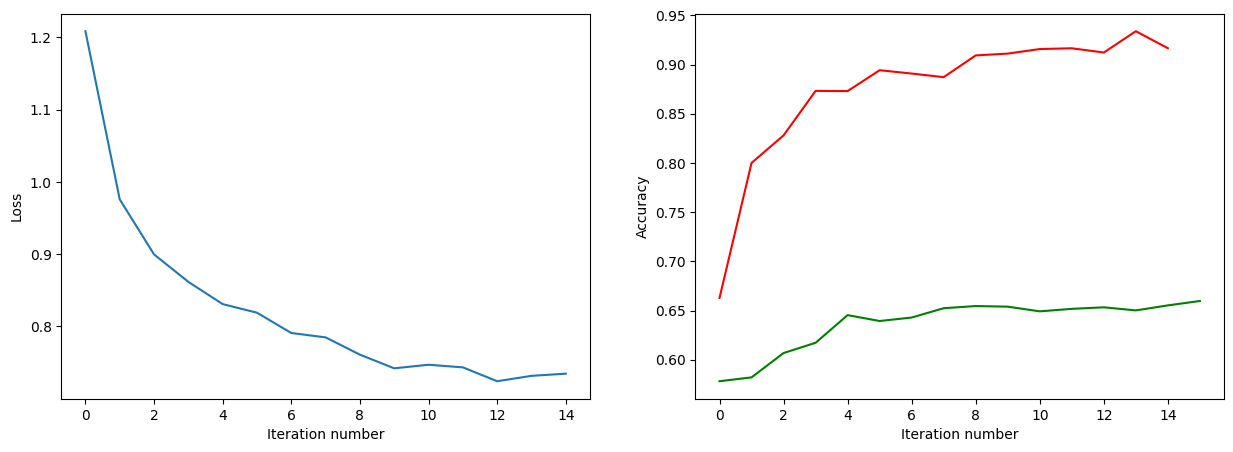

In [47]:
# plot losses
# Initialize matplotlib

fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].plot(list(range(len(steppedloss))), steppedloss)
axs[0].set_xlabel("Iteration number")
axs[0].set_ylabel("Loss")

axs[1].plot(list(range(len(class3acclist))), class3acclist,'-r', label="lbl3_accuracy")
axs[1].plot(list(range(len(plotacc))), plotacc,'-g', label="total_accuracy")
axs[1].set_xlabel("Iteration number")
axs[1].set_ylabel("Accuracy")

# Display
plt.show()

In [49]:
# import ad_labels
# model = torch.load('inceptionv3v3.pt')

model.eval()

correct = 0
total = 0
epoch = 0

for images, labels in test_loader:
    images = images.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    epoch_loss += cost.item()
    total += labels.size(0)
    correct += (predicted == labels.to(device)).sum()

    mdpreds = torch.FloatTensor([3 if pred == 3 else 4 for pred in predicted])
    mdtotal += sum([1 if pred == 3 else 0 for pred in predicted])
    mdcorrect += (mdpreds == labels).sum().item()

epoch_loss /= len(test_loader)
class3acc = mdcorrect/mdtotal
accuracy = correct/total

# class_report = classification_report(labels, predicted.cpu(), target_names=LABELS_LIST, output_dict=True)
# print(f"Epoch {num_epochs}, Accuracy: {class_report['accuracy']}, Lbl3 Acc: {class3acc}")

class3acclist.append(class3acc)
steppedloss.append(cost.item())
totalacc.append(class_report['accuracy'])
predicted = predicted.cpu()

print(f"Loss {epoch_loss}, Accuracy: {accuracy}, Lbl3 Acc: {class3acc}")
print(classification_report(labels.cpu(), predicted.cpu(), target_names=LABELS_LIST))

/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss 0.7810403008759021, Accuracy: 0.589062511920929, Lbl3 Acc: 0.9287733182589033
                    precision    recall  f1-score   support

      Non_Demented       0.79      0.70      0.74        33
Very_Mild_Demented       0.38      0.48      0.43        27
     Mild_Demented       0.59      0.87      0.70        31
 Moderate_Demented       1.00      0.51      0.68        37

          accuracy                           0.64       128
         macro avg       0.69      0.64      0.64       128
      weighted avg       0.72      0.64      0.65       128



In [ ]:
torch.save(model, 'inceptionv3_standard_0.pt')

# Inceptionv3 with Batch normalization
Attempt to counter overfitting by generalizing the model more.

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

model = models.inception_v3(pretrained=True)
model.aux_logits = False

for parameter in model.parameters():
    parameter.requires_grad = False
    
for name, module in model.named_children():
    if isinstance(module, nn.Conv2d):
        # Insert BatchNorm layer after each Conv2d layer
        setattr(model, name, nn.Sequential(module, nn.BatchNorm2d(module.out_channels)))



# model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 10), nn.Linear(10, 2))
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 4))

model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4
)

# print(model.eval())
num_epochs = 15
losses = []
steppedloss = []
class3acclist = []
totalacc = []

cap = []
lowestcost = float('inf')
for epoch in range(num_epochs):
    total_batch = len(train_dataset) // batch_size
    epoch_loss = 0
    mdtotal = 0
    mdcorrect = 0
    correct = 0
    total = 0
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.to(device)
        Y = batch_labels.to(device)

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        _, predicted = torch.max(pre.data, 1) # get predicted values for error

        if (i + 1) % 5 == 0:
            losses.append(cost.item())
            print(
                "Epoch [%d/%d], lter [%d/%d] Loss: %.4f"
                % (epoch + 1, num_epochs, i + 1, total_batch, cost.item())
            )
        
        epoch_loss += cost.item()
        total += labels.size(0)
        correct += (predicted.cpu() == batch_labels).sum().item()
        
        mdpreds = torch.FloatTensor([3 if pred == 3 else 4 for pred in predicted])
        mdtotal += sum([1 if pred == 3 else 0 for pred in predicted])
        mdcorrect += (mdpreds == batch_labels).sum().item()

    class3acc = mdcorrect/mdtotal
    accuracy = correct/total
    epoch_loss /= len(train_loader)
    
    # class_report = classification_report(batch_labels, predicted.cpu(), target_names=LABELS_LIST, output_dict=True)
    print(f"Epoch {num_epochs}, Accuracy: {accuracy}, Lbl3 Acc: {class3acc}")
    
    class3acclist.append(class3acc)
    steppedloss.append(epoch_loss)
    totalacc.append(accuracy)
    predicted = predicted.cpu()

print(classification_report(batch_labels, predicted.cpu(), target_names=LABELS_LIST))

# Save the captured output to a text file
# with open('inceptionv3batchnormv3.txt', 'w') as file:
    # file.write(i for i in stdoutput)


Epoch [1/15], lter [5/40] Loss: 1.3932
Epoch [1/15], lter [10/40] Loss: 1.3057
Epoch [1/15], lter [15/40] Loss: 1.2537
Epoch [1/15], lter [20/40] Loss: 1.1850
Epoch [1/15], lter [25/40] Loss: 1.1495
Epoch [1/15], lter [30/40] Loss: 1.0867
Epoch [1/15], lter [35/40] Loss: 1.0553
Epoch [1/15], lter [40/40] Loss: 1.0785
Epoch 15, Accuracy: 0.4833984375, Lbl3 Acc: 0.6712827988338192
Epoch [2/15], lter [5/40] Loss: 0.9669
Epoch [2/15], lter [10/40] Loss: 1.0665
Epoch [2/15], lter [15/40] Loss: 0.9487
Epoch [2/15], lter [20/40] Loss: 1.0484
Epoch [2/15], lter [25/40] Loss: 1.0624
Epoch [2/15], lter [30/40] Loss: 0.9416
Epoch [2/15], lter [35/40] Loss: 0.9677
Epoch [2/15], lter [40/40] Loss: 0.9506
Epoch 15, Accuracy: 0.5921875, Lbl3 Acc: 0.8070422535211268
Epoch [3/15], lter [5/40] Loss: 0.8915
Epoch [3/15], lter [10/40] Loss: 0.9097
Epoch [3/15], lter [15/40] Loss: 0.9035
Epoch [3/15], lter [20/40] Loss: 0.9063
Epoch [3/15], lter [25/40] Loss: 0.8652
Epoch [3/15], lter [30/40] Loss: 0.9871


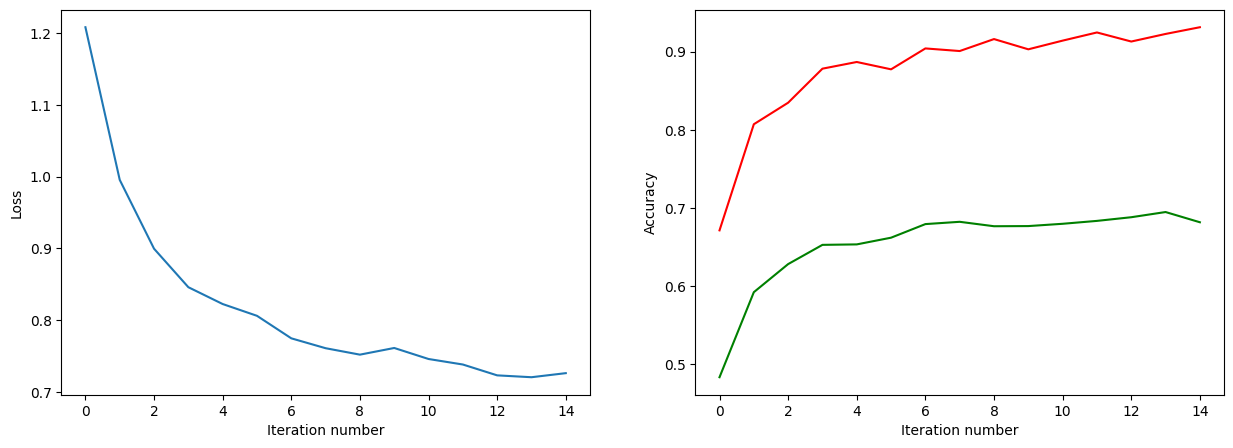

In [53]:
# plot losses
total = 0
plotacc = []
for i, j in enumerate(totalacc):
    total += j
    plotacc.append(total/(i+1))

# Initialize matplotlib
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].plot(list(range(len(steppedloss))), steppedloss)
axs[0].set_xlabel("Iteration number")
axs[0].set_ylabel("Loss")

axs[1].plot(list(range(len(class3acclist))), class3acclist,'-r', label="lbl3_accuracy")
axs[1].plot(list(range(len(totalacc))), totalacc,'-g', label="total_accuracy")
axs[1].set_xlabel("Iteration number")
axs[1].set_ylabel("Accuracy")

# Display
plt.show()

In [54]:
# import ad_labels
# model = torch.load('inceptionv3v3.pt')

model.eval()

correct = 0
total = 0
epoch = 0

for images, labels in test_loader:
    images = images.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    epoch_loss += cost.item()
    total += labels.size(0)
    correct += (predicted == labels.to(device)).sum()

    mdpreds = torch.FloatTensor([3 if pred == 3 else 4 for pred in predicted])
    mdtotal += sum([1 if pred == 3 else 0 for pred in predicted])
    mdcorrect += (mdpreds == labels).sum().item()

epoch_loss /= len(test_loader)
class3acc = mdcorrect/mdtotal
accuracy = correct/total

# class_report = classification_report(labels, predicted.cpu(), target_names=LABELS_LIST, output_dict=True)
# print(f"Epoch {num_epochs}, Accuracy: {class_report['accuracy']}, Lbl3 Acc: {class3acc}")

class3acclist.append(class3acc)
steppedloss.append(cost.item())
totalacc.append(class_report['accuracy'])
predicted = predicted.cpu()

print(f"Loss {epoch_loss}, Accuracy: {accuracy}, Lbl3 Acc: {class3acc}")
print(classification_report(labels.cpu(), predicted.cpu(), target_names=LABELS_LIST))

/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss 0.8181416015326978, Accuracy: 0.5570312738418579, Lbl3 Acc: 0.9316730523627076
                    precision    recall  f1-score   support

      Non_Demented       0.68      0.44      0.54        34
Very_Mild_Demented       0.46      0.35      0.40        34
     Mild_Demented       0.41      0.82      0.55        28
 Moderate_Demented       0.96      0.72      0.82        32

          accuracy                           0.57       128
         macro avg       0.63      0.58      0.58       128
      weighted avg       0.63      0.57      0.57       128



In [55]:
torch.save(model, 'inceptionv3_batchnorm_0.pt')

# Standard 2 Layer CNN Model 
Model was still severely overfitting. We decided to decrease the size of the model making it a 2 layer network.

In [29]:
import torch.optim as optim
from datasetv3 import datasetv4

def train(model, train_loader, epochs = 10, lr = 0.001):
    # Use Adam optimizer to update model weights
    optimizer = optim.Adam(model.parameters(), lr = lr)
    # Use cross-entropy loss function
    criterion = nn.CrossEntropyLoss()
    # Performance curves data
    train_losses = []
    train_accuracies = []

    # num_epochs = 15
    # steppedloss = []
    # totalacc = []
    class3acclist = []
    
    model = model.to(device)

    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        mdtotal = 0
        mdcorrect = 0
        # Iterate over training data
        for batch_number, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            # Compute model output and loss
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (batch_number + 1) % 5 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
                
            
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_loader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')

        # Set model to evaluation mode
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0

        mdpreds = torch.FloatTensor([3 if pred == 3 else 4 for pred in predicted]).to(device)
        mdtotal += sum([1 if pred == 3 else 0 for pred in predicted])
        mdcorrect += (mdpreds == labels).sum().item()
    
        class3acc = mdcorrect/mdtotal
        
        # class_report = classification_report(batch_labels, predicted.cpu(), target_names=LABELS_LIST, output_dict=True)
        # print(f"Epoch {num_epochs}, Accuracy: {class_report['accuracy']}, Lbl3 Acc: {class3acc}")
        
        class3acclist.append(class3acc)
        # steppedloss.append(cost.item())
        # totalacc.append(class_report['accuracy'])
        predicted = predicted.cpu()
            
    print(classification_report(labels.cpu(), predicted.cpu(), target_names=LABELS_LIST))
    return train_losses, train_accuracies, class3acclist


In [49]:
# Iterate over test data
def test(model, test_loader, epochs = 10, lr = 0.001):
    test_losses = []
    test_accuracies = []
    criterion = nn.CrossEntropyLoss()

    # steppedloss = []
    # totalacc = []
    class3acclist = []
    mdtotal = 0
    mdcorrect = 0
    epoch_loss = 0
    total = 0
    correct = 0
    
    
    for inputs, labels in test_loader:
        # Get from dataloader and send to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Compute model output and loss
        # (No grad computation here, as it is the test data)
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
        # Accumulate loss and correct predictions for epoch
        epoch_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        mdpreds = torch.FloatTensor([3 if pred == 3 else 4 for pred in predicted]).to(device)
        mdtotal += sum([1 if pred == 3 else 0 for pred in predicted])
        mdcorrect += (mdpreds == labels).sum().item()
    
        class3acc = mdcorrect/mdtotal
        class3acclist.append(class3acc)
        # predicted = predicted.cpu()
            
        # Calculate epoch loss and accuracy
        epoch_loss /= len(test_loader)
        epoch_acc = correct/total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
    
    print(classification_report(labels.cpu(), predicted.cpu(), target_names=LABELS_LIST))

    return test_losses, test_accuracies, class3acclist

In [38]:
# standard convolution model
class Az_CNN(nn.Module):
  def __init__(self):
    super(Az_CNN, self).__init__()
    # two convolutional layers
    self.conv1 = nn.Conv2d(3,32, kernel_size=3, stride=1, padding=1 )
    self.conv2 = nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1)

    # two fully connected layers
    self.fc1 = nn.Linear(28*28*64, 128) # 28*28*3 = 50176 # [128, 224, 224, 3]
    self.fc2 = nn.Linear(128, 4)

  def forward(self, x):
      
      x = self.conv1(x)
      x = F.relu(x)
    
      x = self.conv2(x)
      x = F.relu(x)

      # Flatten output of second conv layer
      x = x.view(-1, 28*28*64)
      # Pass flattened output through first Linear layer
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      return x


In [65]:
model = Az_CNN().to(device)
model.eval()

Az_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [66]:
resize = 28
train_loader, test_loader, train_dataset, test_dataset = datasetv3(resize)

100%|██████████| 4/4 [00:00<00:00, 140.55it/s]


In [67]:
train_losses, train_accuracies, class3acclist = train(model, train_loader, epochs = 13, lr = 1e-3)

c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1/13, Batch number: 4, Cumulated accuracy: 0.2859375
Epoch 1/13, Batch number: 9, Cumulated accuracy: 0.28046875
Epoch 1/13, Batch number: 14, Cumulated accuracy: 0.2942708333333333
Epoch 1/13, Batch number: 19, Cumulated accuracy: 0.327734375
Epoch 1/13, Batch number: 24, Cumulated accuracy: 0.36625
Epoch 1/13, Batch number: 29, Cumulated accuracy: 0.39427083333333335
Epoch 1/13, Batch number: 34, Cumulated accuracy: 0.41875
Epoch 1/13, Batch number: 39, Cumulated accuracy: 0.4404296875
--- Epoch 1/13: Train loss: 1.4241, Train accuracy: 0.4404
Epoch 2/13, Batch number: 4, Cumulated accuracy: 0.59375
Epoch 2/13, Batch number: 9, Cumulated accuracy: 0.62421875
Epoch 2/13, Batch number: 14, Cumulated accuracy: 0.6359375
Epoch 2/13, Batch number: 19, Cumulated accuracy: 0.652734375
Epoch 2/13, Batch number: 24, Cumulated accuracy: 0.65375
Epoch 2/13, Batch number: 29, Cumulated accuracy: 0.6578125
Epoch 2/13, Batch number: 34, Cumulated accuracy: 0.6642857142857143
Epoch 2/13, Batc

In [68]:
# Label 3 final accuracy
print(class3acclist[-1])

0.9977272727272727


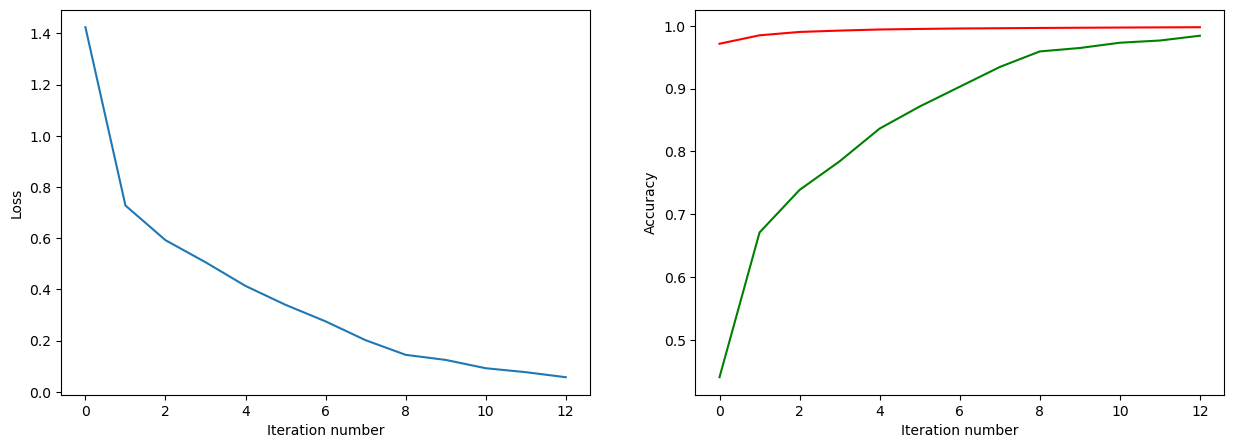

In [69]:
# plot losses

# Initialize matplotlib
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].plot(list(range(len(train_losses))), train_losses)
axs[0].set_xlabel("Iteration number")
axs[0].set_ylabel("Loss")
# axs[1].plot(list(range(len(steppedloss))), steppedloss)
# axs[1].set_xlabel("Iteration number")
# axs[1].set_ylabel("Loss (in logarithmic scale)")
# axs[1].set_yscale("log")

axs[1].plot(list(range(len(class3acclist))), class3acclist,'-r', label="lbl3_accuracy")
axs[1].plot(list(range(len(train_accuracies))), train_accuracies,'-g', label="train_accuracies")
axs[1].set_xlabel("Iteration number")
axs[1].set_ylabel("Accuracy")

# Display
plt.show()

In [70]:
test_losses, test_accuracies, class3acclist = test(model, \
                                                                     test_loader, \
                                                                     epochs = 1, \
                                                                     lr = 1e-3)

c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


--- Epoch 15/1: Test loss: 0.0086, Test accuracy: 0.9844
--- Epoch 15/1: Test loss: 0.0081, Test accuracy: 0.9805
--- Epoch 15/1: Test loss: 0.0218, Test accuracy: 0.9609
--- Epoch 15/1: Test loss: 0.0288, Test accuracy: 0.9570
--- Epoch 15/1: Test loss: 0.0137, Test accuracy: 0.9578
--- Epoch 15/1: Test loss: 0.0180, Test accuracy: 0.9570
--- Epoch 15/1: Test loss: 0.0133, Test accuracy: 0.9598
--- Epoch 15/1: Test loss: 0.0119, Test accuracy: 0.9580
--- Epoch 15/1: Test loss: 0.0104, Test accuracy: 0.9609
--- Epoch 15/1: Test loss: 0.0099, Test accuracy: 0.9625
                    precision    recall  f1-score   support

      Non_Demented       0.96      0.93      0.95        28
Very_Mild_Demented       0.95      0.97      0.96        38
     Mild_Demented       1.00      1.00      1.00        29
 Moderate_Demented       1.00      1.00      1.00        33

          accuracy                           0.98       128
         macro avg       0.98      0.98      0.98       128
      we

In [71]:
torch.save(model, 'stdCNN.pt')